In [1]:
import random
import numpy as np
import torch
import os
import pathlib
import pickle
import pandas as pd
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from Performance import performance_evaluation
perfs = performance_evaluation()

In [2]:
def Data_Simulator(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump):
    from Data import data_generation
    data_gen = data_generation()
    # W_star = data_gen.generate_truth(DataPath,lower, upper, p, d, coef_seed,data_generation_process) 
    # print("W_star = ",W_star[0,:])
    np.random.seed(coef_seed)
    # random.seed(coef_seed)
    # seed_arr = random.sample(range(1, 10000 + 1), len(iteration_all))

    seed_arr = [coef_seed for k in range(100)]
    x_test_all = {}; c_test_all = {}; x_train_all = {}; c_train_all = {}; W_star_all = {}; noise_train_all = {}; noise_test_all = {}
    for iter in iteration_all:
        DataPath_iter = DataPath +"iter="+str(iter)+"/"
        pathlib.Path(DataPath_iter).mkdir(parents=True, exist_ok=True)
        W_star = data_gen.generate_truth(DataPath_iter,lower, upper, p, d, iter,data_generation_process) 
        # print("W_star=",W_star[0,:])
        x_test_all[iter], c_test_all[iter], x_train_all[iter], c_train_all[iter], noise_train_all[iter],noise_test_all[iter],W_star_all[iter] \
        = data_gen.generate_samples(iter,DataPath_iter,p, d, num_test, num_train, alpha, W_star, mis, num_test, data_generation_process, x_dist, e_dist, x_low, x_up, x_mean, x_var, bump) 
    return x_test_all, c_test_all, x_train_all, c_train_all, noise_train_all,noise_test_all,W_star_all

In [3]:
def Implement_Oracle(arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,iteration_all,num_feat,data_generation_process):
    cost_Oracle_Post = {}; cost_Oracle_Ante = {}
    for iter in iteration_all:
        if data_generation_process == "SPO_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T)/np.sqrt(num_feat) + 3
            cost_oracle_pred = (cost_oracle_ori ** mis + 1).T
            # cost_Oracle_Post[iter] = perfs.compute_SPO_out_of_sample_Cost_Ex_Post(arcs, grid,cost_oracle_pred,cost_oracle_pred,noise_test_all[iter])
            cost_Oracle_Ante[iter] = perfs.compute_SPO_out_of_sample_Cost_Ex_Ante(arcs, grid,cost_oracle_pred,cost_oracle_pred)
            # print("Oracle: iter=",iter,",cost_Oracle_Post=",np.nanmean(cost_Oracle_Post[iter]),",cost_Oracle_Ante=",np.nanmean(cost_Oracle_Ante[iter]))

        if data_generation_process == "DDR_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T) + bump
            cost_oracle_pred = (cost_oracle_ori ** mis).T
            cost_Oracle_Post[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_oracle_pred,cost_oracle_pred,noise_test_all[iter],True)
            cost_Oracle_Ante[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_oracle_pred,cost_oracle_pred,noise_test_all[iter],False)
            # print("Oracle: iter=",iter,",cost_Oracle_Post=",np.nanmean(cost_Oracle_Post[iter]),",cost_Oracle_Ante=",np.nanmean(cost_Oracle_Ante[iter]))
        if iter % 20 == 0 and iter > 0:
            print("Oracle: iter=",iter,",cost_Oracle_Ante=",np.nanmean(cost_Oracle_Ante[iter]))
            # print("Oracle: iter=",iter,",cost_Oracle_Post=",np.nanmean(cost_Oracle_Post[iter]),",cost_Oracle_Ante=",np.nanmean(cost_Oracle_Ante[iter]))
    return cost_Oracle_Post,cost_Oracle_Ante

In [4]:
def Implement_OLS(arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,iteration_all,num_feat,data_generation_process):
    from OLS import ols_method
    ols_method_obj = ols_method()
    W_ols_all = {}; w0_ols_all = {}; t_ols_all = {}; obj_ols_all = {}
    cost_OLS_Post = {}; cost_OLS_Ante = {}
    for iter in iteration_all:
        # compute OLS performance
        W_ols_all[iter], w0_ols_all[iter], t_ols_all[iter], obj_ols_all[iter] = ols_method_obj.ols_solver("",x_train_all[iter], c_train_all[iter])
        cost_dem = (W_ols_all[iter] @ x_test_all[iter].T).T + w0_ols_all[iter]

        if data_generation_process == "SPO_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T)/np.sqrt(num_feat) + 3
            cost_oracle_pred = (cost_oracle_ori ** mis + 1).T
            # cost_OLS_Post[iter] = perfs.compute_SPO_out_of_sample_Cost_Ex_Post(arcs, grid,cost_dem,cost_oracle_pred,noise_test_all[iter])
            cost_OLS_Ante[iter] = perfs.compute_SPO_out_of_sample_Cost_Ex_Ante(arcs, grid,cost_dem,cost_oracle_pred)
            # print("Oracle: iter=",iter,",cost_OLS_Post=",np.nanmean(cost_OLS_Post[iter]),",cost_OLS_Ante=",np.nanmean(cost_OLS_Ante[iter]))

        if data_generation_process == "DDR_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T) + bump
            cost_oracle_pred = (cost_oracle_ori ** mis).T
            cost_OLS_Post[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_dem,cost_oracle_pred,noise_test_all[iter],True)
            cost_OLS_Ante[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_dem,cost_oracle_pred,noise_test_all[iter],False)
        if iter % 20 == 0 and iter > 0:
            print("OLS: iter=",iter,",cost_OLS_Ante=",np.nanmean(cost_OLS_Ante[iter]))
            # print("OLS: iter=",iter,",cost_OLS_Post =",np.nanmean(cost_OLS_Post[iter]),",cost_OLS_Ante=",np.nanmean(cost_OLS_Ante[iter]))
    return cost_OLS_Post,cost_OLS_Ante

In [5]:
def Implement_DDR(mu_all,lamb_all,arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,iteration_all,num_feat,data_generation_process):
    from DDR import DDR_method
    ddr_object = DDR_method()
    num_nodes = grid[0] * grid[0]

    w0_ddr_dict = {}; W_ddr_dict = {}
    cost_DDR_Post = {}; cost_DDR_Ante = {}
    for iter in iteration_all:
        for mu in mu_all:
            for lamb in lamb_all:
                w0_ddr_dict[iter,mu,lamb],W_ddr_dict[iter,mu,lamb],alpha_rst,obj_ddr = ddr_object.solve_DDR(arcs,lamb,mu,num_nodes,x_train_all[iter],c_train_all[iter])
                cost_pred = (W_ddr_dict[iter,mu,lamb] @ x_test_all[iter].T).T + w0_ddr_dict[iter,mu,lamb]
                if data_generation_process == "SPO_Data_Generation":
                    cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T)/np.sqrt(num_feat) + 3
                    cost_oracle_pred = (cost_oracle_ori ** mis + 1).T
                    # cost_DDR_Post[iter,mu,lamb] = perfs.compute_SPO_out_of_sample_Cost_Ex_Post(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter])
                    cost_DDR_Ante[iter,mu,lamb] = perfs.compute_SPO_out_of_sample_Cost_Ex_Ante(arcs, grid,cost_pred,cost_oracle_pred)

                if data_generation_process == "DDR_Data_Generation":
                    cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T) + bump
                    cost_oracle_pred = (cost_oracle_ori ** mis).T
                    # cost_DDR_with_noise_all[iter,mu,lamb] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter],True)
                    cost_DDR_Ante[iter,mu,lamb] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter],False)
        if iter % 20 == 0 and iter > 0:
            print("DDR: iter=",iter,",mu=",mu,",lamb=",lamb,",cost_DDR_Ante =",np.nanmean(cost_DDR_Ante[iter,mu,lamb]))
            # print("DDR: iter=",iter,",mu=",mu,",lamb=",lamb,",cost_DDR_Post =",np.nanmean(cost_DDR_Post[iter,mu,lamb]),
            #       ",cost_DDR_Ante =",np.nanmean(cost_DDR_Ante[iter,mu,lamb]))
    return cost_DDR_Post,cost_DDR_Ante

In [6]:
def Implement_EPO(DataPath,iteration_all,batch_size,num_epochs,method_names,W_star_all,bump,x_train_all,c_train_all,x_test_all,noise_test_all,\
                  arcs,grid,epo_runner,perfs,num_feat,mis,data_generation_process):
    W_EPO_all = {}; w0_EPO_all = {}
    cost_EPO_Post = {}; cost_EPO_Ante = {}
    for iter in iteration_all:
        DataPath_seed = DataPath +"iter="+str(iter)+"/"
        pathlib.Path(DataPath_seed).mkdir(parents=True, exist_ok=True)
        W_EPO_all[iter],w0_EPO_all[iter] = epo_runner.run(method_names,DataPath_seed,batch_size,num_feat,grid,num_epochs,\
                                        x_train_all[iter],c_train_all[iter],arcs)
        
        cost_pred = (W_EPO_all[iter] @ x_test_all[iter].T).T + w0_EPO_all[iter]
        if data_generation_process == "SPO_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T)/np.sqrt(num_feat) + 3
            non_negative_cols = (cost_oracle_ori > 0).all(axis=0)
            cost_oracle_ori = cost_oracle_ori[:,non_negative_cols]
            cost_oracle_pred = (cost_oracle_ori ** mis + 1).T
            
            cost_pred = cost_pred[non_negative_cols,:]
            # cost_EPO_Post[iter] = perfs.compute_SPO_out_of_sample_Cost_Ex_Post(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter])
            cost_EPO_Ante[iter] = perfs.compute_SPO_out_of_sample_Cost_Ex_Ante(arcs, grid,cost_pred,cost_oracle_pred)

        if data_generation_process == "DDR_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T) + bump
            cost_oracle_pred = (cost_oracle_ori ** mis).T
            cost_EPO_Ante[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter],False)
            cost_EPO_Post[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter],True)

        if iter % 20 == 0 and iter > 0:
            print(method_names,": iter=",iter,",cost_EPO_Ante=",np.nanmean(cost_EPO_Ante[iter]))
            # print(method_names,": iter=",iter,",cost_EPO_Post =",np.nanmean(cost_EPO_Post[iter]),",cost_EPO_Ante=",np.nanmean(cost_EPO_Ante[iter]))
    return cost_EPO_Post,cost_EPO_Ante

## Parameters

In [7]:
num_train = 100 # number of training data
num_feat = 5 # size of feature
num_test = 1000
deg = 1.0 # polynomial degree
e = 0.5 # scale of normal std or the range of uniform. For the error term

lower = 0 # coef lower bound
upper = 1 # coef upper bound
p = num_feat # num of features
# d = (grid[0] - 1) * (grid[0] - 1) * 2 + 2 * (grid[0] - 1) # num of arcs
# num_nodes = grid[0]*grid[0]
alpha = e # scale of normal std or the range of uniform. For the error term
mis = deg # model misspecification
coef_seed = 1

x_dist = 'uniform'
e_dist = 'normal'
x_low = -2
x_up = 2
x_mean = 2
x_var = 2
bump = 100

# iteration_all = 1
data_generation_process = "SPO_Data_Generation"
# data_generation_process = "DDR_Data_Generation"

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
project_directory = os.path.dirname(os.path.dirname(os.path.dirname(parent_directory)))

### Network

In [ ]:
grid_all = [(2,2),(3,3),(4,4),(5,5)]
middle_path = '/Data_JOC_R1/Shortest_Path/Baseline_Final/'
x_test_grid = {}; c_test_grid = {}; x_train_grid = {}; c_train_grid = {}; noise_train_grid = {}; noise_test_grid = {}; W_star_grid = {}
iteration_all = np.arange(0,100)
for grid in grid_all:

    from Network import network_design
    Network = network_design()
    arcs,arc_index_mapping = Network._getArcs(grid)
    L_N = grid[0]
    d = (L_N - 1) * (L_N - 1) * 2 + 2 * (L_N - 1) # num of arcs
    num_nodes = L_N*L_N
    DataPath_parent = project_directory + middle_path +str(L_N)+'by'+str(L_N)+'_grid_' + data_generation_process + "/"
    DataPath = DataPath_parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_same_W/"
    pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
    print("DataPath:", DataPath)

    
    x_test_grid[L_N], c_test_grid[L_N], x_train_grid[L_N], c_train_grid[L_N],noise_train_grid[L_N],noise_test_grid[L_N],W_star_grid[L_N] \
    = Data_Simulator(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump)

    with open(DataPath+'x_test_grid.pkl', "wb") as tf:
        pickle.dump(x_test_grid[L_N],tf)
    with open(DataPath+'c_test_grid.pkl', "wb") as tf:
        pickle.dump(c_test_grid[L_N],tf)
    with open(DataPath+'x_train_grid.pkl', "wb") as tf:
        pickle.dump(x_train_grid[L_N],tf)
    with open(DataPath+'c_train_grid.pkl', "wb") as tf:
        pickle.dump(c_train_grid[L_N],tf)
    with open(DataPath+'noise_train_grid.pkl', "wb") as tf:
        pickle.dump(noise_train_grid[L_N],tf)
    with open(DataPath+'noise_test_grid.pkl', "wb") as tf:
        pickle.dump(noise_test_grid[L_N],tf)
    with open(DataPath+'W_star_grid.pkl', "wb") as tf:
        pickle.dump(W_star_grid[L_N],tf)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Baseline_Final/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.0_e=0.5_d=4_x_dist=uniform_num_test=1000_same_W/


In [9]:
cost_Oracle_Post_all = {}; cost_Oracle_Ante_all = {}
cost_OLS_Post_all = {}; cost_OLS_Ante_all = {}
cost_DDR_Post_all = {}; cost_DDR_Ante_all = {}

for grid in grid_all:
    from Network import network_design
    Network = network_design()
    arcs,arc_index_mapping = Network._getArcs(grid)

    print("grid = ",grid)
    L_N = grid[0]
    d = (L_N - 1) * (L_N - 1) * 2 + 2 * (L_N - 1) # num of arcs
    num_nodes = L_N*L_N
    DataPath_parent = project_directory + middle_path +str(L_N)+'by'+str(L_N)+'_grid_' + data_generation_process + "/"
    DataPath = DataPath_parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
    print("DataPath:", DataPath)

    cost_Oracle_Post_all[L_N],cost_Oracle_Ante_all[L_N] = Implement_Oracle(arcs, grid,mis,bump,\
                                                        W_star_grid[L_N],x_test_grid[L_N],noise_test_grid[L_N],\
                                                        iteration_all,num_feat,data_generation_process)

    cost_OLS_Post_all[L_N],cost_OLS_Ante_all[L_N] = Implement_OLS(arcs, grid,mis,bump,\
                                                W_star_grid[L_N],x_test_grid[L_N],noise_test_grid[L_N],x_train_grid[L_N],c_train_grid[L_N],\
                                                iteration_all,num_feat,data_generation_process)


    mu_all = np.round(np.arange(0.1,1.0,0.1),4)
    lamb_all = np.round(np.arange(0.0,1.0,0.1),4)
    cost_DDR_Post_all[L_N],cost_DDR_Ante_all[L_N] = Implement_DDR(mu_all,lamb_all,arcs, grid,mis,bump,\
                                                                  W_star_grid[L_N],x_test_grid[L_N],noise_test_grid[L_N],x_train_grid[L_N],c_train_grid[L_N],\
                                                                    iteration_all,num_feat,data_generation_process)

    # with open(DataPath+'cost_Oracle_Post.pkl', "wb") as tf:
    #     pickle.dump(cost_Oracle_Post,tf)
    # with open(DataPath+'cost_Oracle_Ante.pkl', "wb") as tf:
    #     pickle.dump(cost_Oracle_Ante,tf)

grid =  (2, 2)
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Baseline_Final/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.0_e=0.5_d=4_x_dist=uniform_num_test=1000_diff_W/
Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-13
Oracle: iter= 20 ,cost_Oracle_Ante= 7.636899840033395
Oracle: iter= 40 ,cost_Oracle_Ante= 7.709997556944255
Oracle: iter= 60 ,cost_Oracle_Ante= 7.7524276049541685
Oracle: iter= 80 ,cost_Oracle_Ante= 7.5811517962362505
OLS: iter= 20 ,cost_OLS_Ante= 7.64772533514242
OLS: iter= 40 ,cost_OLS_Ante= 7.792749341506423
OLS: iter= 60 ,cost_OLS_Ante= 7.794495197048333
OLS: iter= 80 ,cost_OLS_Ante= 7.604090181960109
DDR: iter= 20 ,mu= 0.9 ,lamb= 0.9 ,cost_DDR_Ante = 7.6482690921225505
DDR: iter= 40 ,mu= 0.9 ,lamb= 0.9 ,cost_DDR_Ante = 7.788925283665736
DDR: iter= 60 ,mu= 0.9 ,lamb= 0.9 ,cost_DDR_Ante = 7.794955470104525
DDR: iter= 80 ,mu= 0.9 ,lamb= 0.9 ,cost_DDR_Ante = 7.6042707553

In [10]:
cost_SPO_Post_all = {}; cost_SPO_Ante_all = {}
for grid in grid_all:
    from Network import network_design
    Network = network_design()
    arcs,arc_index_mapping = Network._getArcs(grid)

    L_N = grid[0]
    d = (L_N - 1) * (L_N - 1) * 2 + 2 * (L_N - 1) # num of arcs
    num_nodes = L_N*L_N
    DataPath_parent = project_directory + middle_path +str(L_N)+'by'+str(L_N)+'_grid_' + data_generation_process + "/"
    DataPath = DataPath_parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
    print("DataPath:", DataPath)

    batch_size = 20
    num_epochs = 1000
    from PYEPO import PyEPO_Method
    epo_runner = PyEPO_Method()
    method_names = ["spo+"]
    cost_SPO_Post_all[L_N],cost_SPO_Ante_all[L_N] = Implement_EPO(DataPath,iteration_all,batch_size,num_epochs,method_names,\
                                                W_star_grid[L_N],bump,x_train_grid[L_N],c_train_grid[L_N],x_test_grid[L_N],noise_test_grid[L_N],\
                                                arcs,grid,epo_runner,perfs,num_feat,mis,data_generation_process)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Baseline_Final/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.0_e=0.5_d=4_x_dist=uniform_num_test=1000_diff_W/
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 11353.45it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15174.21it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16366.74it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16905.70it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16513.01it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15723.14it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15972.22it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 12417.63it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15835.33it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 13347.45it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 14963.62it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 11764.57it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8830.86it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 11442.96it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16709.04it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 12639.16it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 9806.88it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16116.44it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17185.54it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16215.51it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16719.70it/s]


Num of cores: 2
['spo+'] : iter= 20 ,cost_EPO_Ante= 8.042103484963114
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 14755.69it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16076.91it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16204.86it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16786.62it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 13755.42it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 14560.02it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 13935.49it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 12862.02it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16382.08it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16043.70it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 11552.33it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17476.27it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15093.94it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16334.87it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17721.41it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 13509.97it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 12291.00it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 11552.97it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15413.44it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 11087.83it/s]


Num of cores: 2
['spo+'] : iter= 40 ,cost_EPO_Ante= 8.06664540978568
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16139.39it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 14130.32it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 11610.21it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 10166.53it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 13785.72it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 11495.97it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15224.89it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16986.49it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15852.69it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17819.29it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 12906.35it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 11814.61it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 11022.85it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 9680.35it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16447.61it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 14052.68it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15408.34it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17018.88it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16989.93it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 13625.83it/s]


Num of cores: 2
['spo+'] : iter= 60 ,cost_EPO_Ante= 7.847374812925645
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16209.87it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15997.80it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 11453.28it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 10886.10it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15255.90it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 11749.41it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 14679.77it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15535.03it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 11562.20it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 12996.73it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18271.85it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15982.56it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16136.90it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 13913.30it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16667.21it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 13882.91it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 9658.29it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 10646.25it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17004.39it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17577.34it/s]


Num of cores: 2
['spo+'] : iter= 80 ,cost_EPO_Ante= 8.114711650363706
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 9061.32it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15444.08it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17277.57it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15858.08it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 11584.88it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 14773.88it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 11130.79it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15436.69it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17059.73it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 11368.53it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 11489.04it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17190.48it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 11544.70it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 13459.24it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 13939.20it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15550.01it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16561.91it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 13450.18it/s]


Num of cores: 2
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16079.37it/s]


Num of cores: 2


In [11]:
Result_dir = project_directory + middle_path + "Result/"
pathlib.Path(Result_dir).mkdir(parents=True, exist_ok=True)

In [12]:
with open(Result_dir+'cost_Oracle_Post_all.pkl', "wb") as tf:
    pickle.dump(cost_Oracle_Post_all,tf)
with open(Result_dir+'cost_Oracle_Ante_all.pkl', "wb") as tf:
    pickle.dump(cost_Oracle_Ante_all,tf)

with open(Result_dir+'cost_OLS_Post_all.pkl', "wb") as tf:
    pickle.dump(cost_OLS_Post_all,tf)
with open(Result_dir+'cost_OLS_Ante_all.pkl', "wb") as tf:
    pickle.dump(cost_OLS_Ante_all,tf)

with open(Result_dir+'cost_DDR_Post_all.pkl', "wb") as tf:
    pickle.dump(cost_DDR_Post_all,tf)
with open(Result_dir+'cost_DDR_Ante_all.pkl', "wb") as tf:
    pickle.dump(cost_DDR_Ante_all,tf)

with open(Result_dir+'cost_SPO_Post_all.pkl', "wb") as tf:
    pickle.dump(cost_SPO_Post_all,tf)
with open(Result_dir+'cost_SPO_Ante_all.pkl', "wb") as tf:
    pickle.dump(cost_SPO_Ante_all,tf)

## Compare DDR vs OLS

In [13]:
def cross_compare2plus(c_item, c_base, c_oracle):
    N = len(c_item)
    c_diff = c_base - c_item
    lbel = np.zeros((N,1))
    
    equals = np.sum(c_diff == 0)
    wins = np.sum(c_diff > 0) # indicate num of c_item is lower than c_base
    lose = np.sum(c_diff < 0)
    
    lbel[c_diff < 0] = 1
    lbel[c_diff > 0] = -1
    
#     print(N, equals, wins, lose)
    if N == equals:
        win_ratio = 0.5
    else:
        win_ratio = wins/(N - equals)
    cost_reduction = (np.nanmean(c_diff))/np.abs(np.nanmean(c_base))
    if np.nanmean(c_base) - np.nanmean(c_oracle) <= 1e-6:
        regret_reduction = 0.0
    else:
        regret_reduction = (np.nanmean(c_diff))/np.abs(np.nanmean(c_base) - np.nanmean(c_oracle))
    return win_ratio, cost_reduction, regret_reduction

In [14]:
def calculate_H2H_Regret(iteration_all,c_item_all, c_base_all, c_oracle_all):
    h2h = np.zeros(len(iteration_all)); cost_rd = np.zeros(len(iteration_all)); regret_rd = np.zeros(len(iteration_all))
    for iter_index in range(len(iteration_all)):
        iter = iteration_all[iter_index]
        h2h[iter_index],cost_rd[iter_index],regret_rd[iter_index] = cross_compare2plus(c_item_all[iter], c_base_all[iter], c_oracle_all[iter])
    return h2h,cost_rd,regret_rd

In [15]:
h2h_ddr_vs_ols_post = {}; cost_rd_ddr_vs_ols_post = {}; regret_rd_ddr_vs_ols_post = {}
h2h_ddr_vs_ols_ante = {}; cost_rd_ddr_vs_ols_ante = {}; regret_rd_ddr_vs_ols_ante = {}

for grid in grid_all:
    L_N = grid[0]
    for mu in mu_all:
        for lamb in lamb_all:
            cost_ddr_post_tem = {}; cost_ddr_ante_tem = {}
            for iter_index in range(len(iteration_all)):
                iter = iteration_all[iter_index]
                # cost_ddr_post_tem[iter] = cost_DDR_Post_all[L_N][iter,mu,lamb]
                cost_ddr_ante_tem[iter] = cost_DDR_Ante_all[L_N][iter,mu,lamb]

            # h2h_ddr_vs_ols_post[L_N,mu,lamb],cost_rd_ddr_vs_ols_post[L_N,mu,lamb], regret_rd_ddr_vs_ols_post[L_N,mu,lamb] \
            #     = calculate_H2H_Regret(iteration_all,cost_ddr_post_tem, cost_OLS_Post_all[L_N], cost_Oracle_Post_all[L_N])
            
            h2h_ddr_vs_ols_ante[L_N,mu,lamb],cost_rd_ddr_vs_ols_ante[L_N,mu,lamb], regret_rd_ddr_vs_ols_ante[L_N,mu,lamb] \
                = calculate_H2H_Regret(iteration_all,cost_ddr_ante_tem, cost_OLS_Ante_all[L_N], cost_Oracle_Ante_all[L_N])
    print("Grid = ",grid)

Grid =  (2, 2)


In [16]:
from scipy.stats import gaussian_kde
from matplotlib import gridspec
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
def figure_plot_upright(all_x, all_y, figure_name, size = (5, 5), move = [-0.07, 0.07, 0.35, 0.55], 
                        ysame = 0, yrange = [6,6], sublabel = '', ypio = 1):
    
    data = np.asarray([all_x,all_y])

    xmin, ymin = data.min(axis = 1)
    xmax, ymax = data.max(axis = 1)

    xmax, xmin = tuple(np.array([xmax, xmin]) + 0.1*(xmax - xmin)*np.array([1, -1]))
    ymax, ymin = tuple(np.array([ymax, ymin]) + 0.1*(ymax - ymin)*np.array([1, -1]))

    ####### Obtain KDE  

    #KDE for top marginal
    kde_X = gaussian_kde(data[0])
    #KDE for right marginal
    kde_Y = gaussian_kde(data[1])

    x = np.linspace(0, 100, 100)
    y = np.linspace(ymin, ymax, 100)

    dx = kde_X(x) # X-marginal density
    dy = kde_Y(y) # Y-marginal density

    #Define grid for subplots
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios = [1, 3])

    ####### Create scatter plot
    fig = plt.figure(figsize = size)
    ax = plt.subplot(gs[1, 0])
    cax = ax.scatter(data[0], data[1], s = 15, color='#003D7C', marker = "o", edgecolors = "#EF7C00")
    plt.xlabel('Head-to-head (%)')

    plt.ylabel('Regret reduction (%)') #pio
    
    
    if ysame == 0:
        plt.vlines(50, ymin, ymax, linestyle="dashed", alpha = 0.8,color = 'k')
    else:
        plt.vlines(50, yrange[0], yrange[1], linestyle="dashed", alpha = 0.8,color = 'k')
    
    if ypio == 0:
        plt.hlines(0, 0, 100, linestyle="dashed", alpha = 0.8,color = 'k')
        ax.annotate(sublabel, xy = (0.55,0.9), xycoords = 'axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 10)
    elif ypio == 1:
        plt.hlines(0, 0, 100, linestyle="dashed", alpha = 0.8,color = 'k')
        ax.annotate(sublabel, xy = (0.05,0.9), xycoords = 'axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 10)
    else:
        plt.hlines(100, 0, 100, linestyle="dashed", alpha = 0.8,color = 'k') #pio
        ax.annotate(sublabel, xy = (0.55,0.9), xycoords = 'axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 10)

    ####### Create Y-marginal (right)
    axr = plt.subplot(gs[1, 1], xticks = [], yticks = [], frameon = False)
    axr.plot(dy, y, color = 'black')

    if ypio == 0:
        axr.fill_betweenx(y, 0, dy, where = y <= 0.01, alpha = 1, color='#EF7C00')
        axr.fill_betweenx(y, 0, dy, where = y >= 0, alpha = 1, color='#003D7C')

        leftarea = np.round( sum(n <= 0 for n in all_y)/len(all_y),2 )
        rightarea = np.round( sum(n > 0 for n in all_y)/len(all_y),2 )

        axr.annotate(leftarea, xy=(0.15, abs(ymin)/(ymax - ymin) + move[0]), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)
        axr.annotate(rightarea, xy=(0.15, abs(ymin)/(ymax - ymin) + move[1]), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)
    
    elif ypio == 1:
        axr.fill_betweenx(y, 0, dy, where = y <= 0, alpha = 1, color='#EF7C00')
        axr.fill_betweenx(y, 0, dy, where = y >= 0, alpha = 1, color='#003D7C')

        leftarea = np.round( sum(n <= 0 for n in all_y)/len(all_y),2 )
        rightarea = np.round( sum(n > 0 for n in all_y)/len(all_y),2 )

        axr.annotate(leftarea, xy=(0.15, abs(ymin)/(ymax - ymin) + move[0]), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)
        axr.annotate(rightarea, xy=(0.15, abs(ymin)/(ymax - ymin) + move[1]), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)
    else:
        axr.fill_betweenx(y, 0, dy, where = y <= 100, alpha = 1, color='#EF7C00') #pio
        axr.fill_betweenx(y, 0, dy, where = y >= 100, alpha = 1, color='#003D7C') #pio

        leftarea = np.round( sum(n <= 100 for n in all_y)/len(all_y),2 ) #pio
        rightarea = np.round( sum(n > 100 for n in all_y)/len(all_y),2 ) #pio

        axr.annotate(leftarea, xy=(0.15, (100 - ymin)/(ymax - ymin) + move[0]), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)
        axr.annotate(rightarea, xy=(0.15, (100 - ymin)/(ymax - ymin) + move[1]), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)
#     axr.invert_xaxis()

    ####### Create X-marginal (top)
    axt = plt.subplot(gs[0,0], frameon = False, yticks = [], xticks = [])
    #base = pyplot.gca().transData
    #rot = transforms.Affine2D().rotate_deg(180)
    axt.plot(x, dx, color = 'black')
    axt.fill_between(x, 0, dx, where = x >= 49.9, alpha= 1, color = '#003D7C')
    axt.fill_between(x, 0, dx, where = x <= 50, alpha= 1, color = '#EF7C00')

#     axt.invert_yaxis()
    leftarea = np.round( sum(n <= 50 for n in all_x)/len(all_x),2 )
    rightarea = np.round( sum(n > 50 for n in all_x)/len(all_x),2 )

    axt.annotate(leftarea, xy=(move[2], 0.15), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)
    axt.annotate(rightarea, xy=(move[3], 0.15), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)

    ####### Bring the marginals closer to the scatter plot and save eps file
    fig.tight_layout(pad = 1)
    # plt.savefig(figure_name + '.eps', format='eps')
    plt.savefig(figure_name + '.pdf', format='pdf')

In [18]:
# mu = 0.4
# lamb = 0.5
# file_name = Result_dir + 'DDR_vs_OLS_mu='+str(mu)+"_lamb="+str(lamb)+"_post_grid="+str(L_N)
# all_x = h2h_ddr_vs_ols_post[L_N,mu,lamb] * 100
# all_y = regret_rd_ddr_vs_ols_post[L_N,mu,lamb] * 100
# figure_plot_upright(all_x, all_y, file_name, size = (5, 5), move = [-0.07, 0.07, 0.35, 0.55], ysame = 0, yrange = [6,6], sublabel = '', ypio = 0)

In [19]:
Result_dir

'/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Baseline_Final/Result/'

In [20]:
regret_mat = np.zeros((len(mu_all),len(lamb_all)))
L_N = 2
mu_index = 0
for mu in mu_all:
    lamb_index = 0
    for lamb in lamb_all:
        regret_mat[mu_index,lamb_index] = np.round(np.mean(regret_rd_ddr_vs_ols_ante[L_N,mu,lamb]) * 100,2)
        lamb_index = lamb_index + 1
    mu_index = mu_index + 1
regret_df = pd.DataFrame(regret_mat)

In [32]:
regret_df.index = mu_all
regret_df.columns = lamb_all

In [33]:
regret_df

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0.1,0.0,0.67,0.35,0.78,0.44,-0.56,-0.96,-2.27,-3.62,-6.04
0.2,0.0,0.27,0.80,0.81,0.41,0.16,-0.26,-0.35,-1.10,-4.16
0.3,0.0,0.47,0.60,0.72,0.32,0.43,-0.40,-1.10,-2.72,-3.28
0.4,0.0,0.48,0.82,1.04,1.05,1.05,0.65,-0.31,-0.80,-1.18
0.5,0.0,0.19,0.88,1.30,1.01,1.03,0.49,0.38,-0.28,-0.55
0.6,0.0,0.05,0.45,0.90,0.78,0.89,0.68,0.75,0.63,0.16
0.7,0.0,0.21,0.32,0.57,0.62,0.59,0.74,0.48,0.40,0.20
0.8,0.0,0.01,0.09,0.39,0.48,0.54,0.54,0.55,0.42,0.52
0.9,0.0,-0.11,-0.09,-0.04,0.00,0.01,0.07,0.17,0.25,0.27


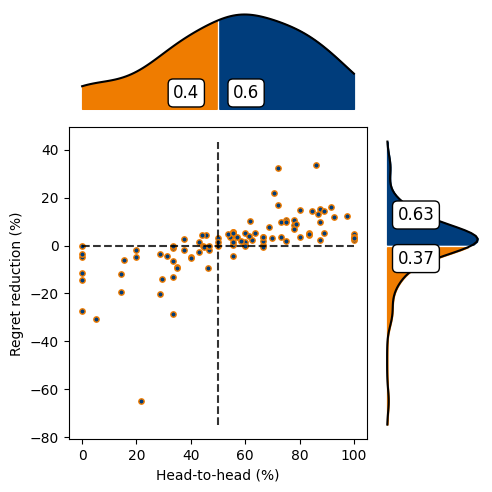

In [35]:
mu = 0.4
lamb = 0.5
file_name = Result_dir + 'DDR_vs_OLS_mu='+str(mu)+"_lamb="+str(lamb)+"_ante_grid="+str(L_N)
all_x = h2h_ddr_vs_ols_ante[L_N,mu,lamb] * 100
all_y = regret_rd_ddr_vs_ols_ante[L_N,mu,lamb] * 100
figure_plot_upright(all_x, all_y, file_name, size = (5, 5), move = [-0.07, 0.07, 0.35, 0.55], ysame = 0, yrange = [6,6], sublabel = '', ypio = 0)

### Impact of Network Structure

In [36]:
def obtain_DDR_vs_OLS_Network_Result(grid_all,mu_all,lamb_all,h2h_ddr_vs_ols_input,regret_rd_ddr_vs_ols_input):
    h2h_avg_all = {}; regret_rd_avg_all = {}
    h2h_prop_all = {}; regret_rd_prop_all = {}

    for grid in grid_all:
        L_N = grid[0]
        h2h_avg = np.zeros((len(mu_all),len(lamb_all))); regret_rd_avg = np.zeros((len(mu_all),len(lamb_all)))
        h2h_prop = np.zeros((len(mu_all),len(lamb_all))); regret_rd_prop = np.zeros((len(mu_all),len(lamb_all)))

        mu_index = 0
        for mu in mu_all:
            lamb_index = 0
            for lamb in lamb_all:
                h2h_ddr_ols_tem = h2h_ddr_vs_ols_input[L_N,mu,lamb]
                regret_rd_ddr_vs_ols_tem = regret_rd_ddr_vs_ols_input[L_N,mu,lamb]

                h2h_avg[mu_index,lamb_index] = np.nanmean(h2h_ddr_ols_tem)
                regret_rd_avg[mu_index,lamb_index] = np.nanmean(regret_rd_ddr_vs_ols_tem)
                
                h2h_prop[mu_index,lamb_index] = len(h2h_ddr_ols_tem[h2h_ddr_ols_tem >= 0.5])/len(h2h_ddr_ols_tem)
                regret_rd_prop[mu_index,lamb_index] = len(regret_rd_ddr_vs_ols_tem[regret_rd_ddr_vs_ols_tem > 0.0])/len(regret_rd_ddr_vs_ols_tem)
        
                lamb_index = lamb_index + 1
            mu_index = mu_index + 1

        h2h_avg_all[L_N] = h2h_avg
        regret_rd_avg_all[L_N] = regret_rd_avg
        h2h_prop_all[L_N] = h2h_prop
        regret_rd_prop_all[L_N] = regret_rd_prop

    return h2h_avg_all,regret_rd_avg_all,h2h_prop_all,regret_rd_prop_all

In [37]:
# ### Post Results
# h2h_ddr_vs_ols_post_avg_all,regret_rd_ddr_vs_ols_post_avg_all,h2h_ddr_vs_ols_post_prop_all,regret_rd_ddr_vs_ols_post_prop_all = \
#     obtain_DDR_vs_OLS_Network_Result(grid_all,mu_all,lamb_all,h2h_ddr_vs_ols_post,regret_rd_ddr_vs_ols_post)

### Ante Results
h2h_ddr_vs_ols_ante_avg_all,regret_rd_ddr_vs_ols_ante_avg_all,h2h_ddr_vs_ols_ante_prop_all,regret_rd_ddr_vs_ols_ante_prop_all = \
    obtain_DDR_vs_OLS_Network_Result(grid_all,mu_all,lamb_all,h2h_ddr_vs_ols_ante,regret_rd_ddr_vs_ols_ante)

In [38]:
regret_avg_max_post = np.zeros(len(grid_all)); regret_avg_max_indices_post = {}
regret_prop_max_post = np.zeros(len(grid_all)); regret_prop_max_indices_post = {}

regret_avg_max_ante = np.zeros(len(grid_all)); regret_avg_max_indices_ante = {}
regret_prop_max_ante = np.zeros(len(grid_all)); regret_prop_max_indices_ante = {}

grid_index = 0
for grid in grid_all:
    L_N = grid[0]
    # ### Post Results
    # regret_avg_max_post[grid_index] = np.max(regret_rd_ddr_vs_ols_post_avg_all[L_N]) * 100
    # max_index = np.unravel_index(np.argmax(regret_rd_ddr_vs_ols_post_avg_all[L_N]), regret_rd_ddr_vs_ols_post_avg_all[L_N].shape)
    # regret_avg_max_indices_post[grid[0]] = (mu_all[max_index[0]],lamb_all[max_index[1]])

    # regret_prop_max_post[grid_index] = np.max(regret_rd_ddr_vs_ols_post_prop_all[L_N])
    # max_index = np.unravel_index(np.argmax(regret_rd_ddr_vs_ols_post_prop_all[L_N]), regret_rd_ddr_vs_ols_post_prop_all[L_N].shape)
    # regret_prop_max_indices_post[grid[0]] = (mu_all[max_index[0]],lamb_all[max_index[1]])


    regret_avg_max_ante[grid_index] = np.max(regret_rd_ddr_vs_ols_ante_avg_all[L_N]) * 100
    max_index = np.unravel_index(np.argmax(regret_rd_ddr_vs_ols_ante_avg_all[L_N]), regret_rd_ddr_vs_ols_ante_avg_all[L_N].shape)
    regret_avg_max_indices_ante[grid[0]] = (mu_all[max_index[0]],lamb_all[max_index[1]])

    regret_prop_max_ante[grid_index] = np.max(regret_rd_ddr_vs_ols_ante_prop_all[L_N])
    max_index = np.unravel_index(np.argmax(regret_rd_ddr_vs_ols_ante_prop_all[L_N]), regret_rd_ddr_vs_ols_ante_prop_all[L_N].shape)
    regret_prop_max_indices_ante[grid[0]] = (mu_all[max_index[0]],lamb_all[max_index[1]])

    grid_index = grid_index + 1

In [26]:
# avg_max_arr = regret_avg_max_post
# prop_max_arr = regret_prop_max_post
# avg_opt_para = regret_avg_max_indices_post
# prop_opt_para = regret_prop_max_indices_post
# # 横坐标只取网格边长
# grid_sizes = [g[0] for g in grid_all]
# # 绘图
# plt.figure(figsize=(8, 5))
# plt.plot(grid_sizes, avg_max_arr, marker='o', linestyle='-', color='b', label='Avg Max Value')
# plt.plot(grid_sizes, prop_max_arr, marker='o', linestyle='-', color='g', label='Proportion Max Value')
# # 添加注释
# for i, size in enumerate(grid_sizes):
#     x_offset, y_offset = avg_opt_para[size]
#     plt.annotate(f"({x_offset:.1f}, {y_offset:.1f})",
#                  (size, avg_max_arr[i]),
#                  textcoords="offset points",
#                  xytext=(15, -20),  # 注释位置偏移
#                  ha='center',
#                  fontsize=10,
#                  color = "blue")

# # 添加注释
# for i, size in enumerate(grid_sizes):
#     x_offset, y_offset = prop_opt_para[size]
#     plt.annotate(f"({x_offset:.1f}, {y_offset:.1f})",
#                  (size, prop_max_arr[i]),
#                  textcoords="offset points",
#                  xytext=(15, 10),  # 注释位置偏移
#                  ha='center',
#                  fontsize=10,
#                  color = "green")
    
# # 坐标轴和标题
# plt.xlabel("Grid Size",fontsize = 16)
# plt.ylabel("Max Value",fontsize = 16)
# plt.title("Max Value vs Grid Size")
# plt.xticks(grid_sizes,fontsize = 12)
# plt.yticks(fontsize = 12)

# plt.grid(True)
# plt.tight_layout()
# plt.legend()
# plt.savefig(Result_dir +"Impact_Network_Structure_Post.pdf", format='pdf')
# plt.show()

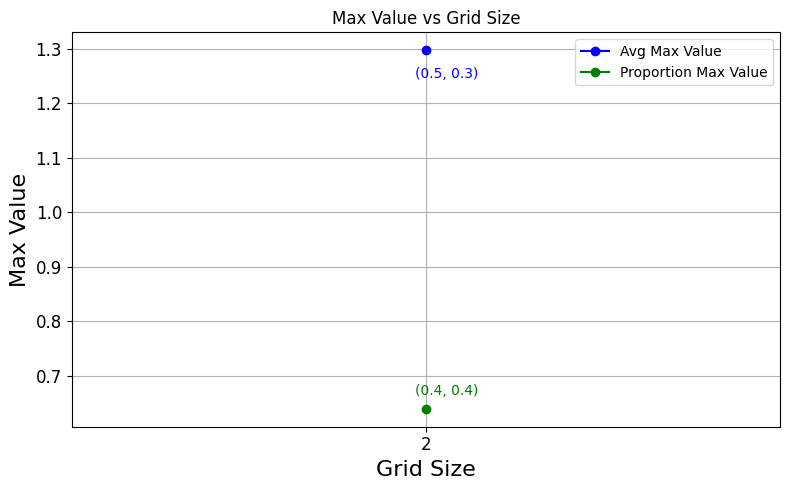

In [39]:
avg_max_arr = regret_avg_max_ante
prop_max_arr = regret_prop_max_ante
avg_opt_para = regret_avg_max_indices_ante
prop_opt_para = regret_prop_max_indices_ante
# 横坐标只取网格边长
grid_sizes = [g[0] for g in grid_all]
# 绘图
plt.figure(figsize=(8, 5))
plt.plot(grid_sizes, avg_max_arr, marker='o', linestyle='-', color='b', label='Avg Max Value')
plt.plot(grid_sizes, prop_max_arr, marker='o', linestyle='-', color='g', label='Proportion Max Value')
# 添加注释
for i, size in enumerate(grid_sizes):
    x_offset, y_offset = avg_opt_para[size]
    plt.annotate(f"({x_offset:.1f}, {y_offset:.1f})",
                 (size, avg_max_arr[i]),
                 textcoords="offset points",
                 xytext=(15, -20),  # 注释位置偏移
                 ha='center',
                 fontsize=10,
                 color = "blue")

# 添加注释
for i, size in enumerate(grid_sizes):
    x_offset, y_offset = prop_opt_para[size]
    plt.annotate(f"({x_offset:.1f}, {y_offset:.1f})",
                 (size, prop_max_arr[i]),
                 textcoords="offset points",
                 xytext=(15, 10),  # 注释位置偏移
                 ha='center',
                 fontsize=10,
                 color = "green")
    
# 坐标轴和标题
plt.xlabel("Grid Size",fontsize = 16)
plt.ylabel("Max Value",fontsize = 16)
plt.title("Max Value vs Grid Size")
plt.xticks(grid_sizes,fontsize = 12)
plt.yticks(fontsize = 12)

plt.grid(True)
plt.tight_layout()
plt.legend()
plt.savefig(Result_dir +"Impact_Network_Structure_Ante.pdf", format='pdf')
plt.show()